In [1]:
#############################################################
# 1. Libraries

import pandas as pd
import numpy as np 
import os
import glob
from tqdm import tqdm
# import tensorflow as tf
# tf.keras.backend.clear_session()

# physical_devices = tf.config.list_physical_devices('GPU')

# try:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
# except:
#     print('Invalid device or cannot modify virtual devices once initialized.')

# from tensorflow.keras import models, layers, regularizers, metrics, losses, optimizers
import matplotlib.pyplot as plt
import gc
from numpy.fft import *
from scipy import signal
from joblib import parallel_backend, Parallel, delayed
from skimage import color, io
from PIL import Image               # to load images
import IPython

import librosa
import librosa.display

#############################################################

In [2]:
#############################################################
# 2. Paths & Global Variables

## 2.1 Paths

path = '../01_Data/'
path_sequences = path + '01_GeneratedSequences/'
path_spectograms = path + '02_GeneratedSpectograms_1/'

df_train = pd.read_csv(path + 'train.csv')
df_sample_submission = pd.read_csv(path + 'sample_submission.csv') 

train_paths = glob.glob(path + 'train/*')
test_paths = glob.glob(path + 'test/*')

unique_segments_id_train = set(df_train['segment_id'])
unique_segments_id_test = set(df_sample_submission['segment_id'])

dict_unique_segments_train_id = { v : k for k, v in enumerate(unique_segments_id_train)}
dict_unique_segments_train_id_inv = { k : v for k, v in enumerate(unique_segments_id_train)}

## 2.2 Global Variables

SEQ_LENGTH = 60_001

#############################################################

In [3]:
#############################################################
# 3. Preprocess

dict_segments_paths_train = {
    segment : path + 'train/' + str(segment) + '.csv' for segment in unique_segments_id_train
}

dict_segments_paths_test = {
    segment : path + 'test/' + str(segment) + '.csv' for segment in unique_segments_id_test
}


dict_segments_sequences_paths_train = {
    segment : path_sequences + 'train/' + str(segment) + '.npy' for segment in unique_segments_id_train
}

dict_segments_sequences_paths_test = {
    segment : path_sequences + 'test/' + str(segment) + '.npy' for segment in unique_segments_id_test
}

dict_segments_spectograms_paths_train = {
    segment : path_spectograms + 'train/' + str(segment) + '/' for segment in unique_segments_id_train
}

dict_segments_spectograms_paths_test = {
    segment : path_spectograms + 'test/' + str(segment) + '/' for segment in unique_segments_id_test
}


#############################################################

In [4]:
SAMPLING_RATE = 100 
DURATION = 600
SAMPLES = SAMPLING_RATE * DURATION
N_MELS = 128
HOP_LENGTH = 256 # 256
FMIN = 0
FMAX = SAMPLING_RATE // 2
N_FFT = N_MELS * 20 #2048

def readFile(pathname, sensor=0, mask_value=0):
    y = pd.read_csv(pathname).fillna(mask_value).values[-SAMPLES:, sensor]
    return y


def fileToMelspectrogram(file):
    spectrogram = librosa.feature.melspectrogram(file, 
                                                 sr=SAMPLING_RATE,
                                                 n_mels=N_MELS,
                                                 hop_length=HOP_LENGTH,
                                                 n_fft=N_FFT,
                                                 fmin=FMIN,
                                                 fmax=FMAX)
    
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def showMelspectrogram(mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=SAMPLING_RATE, hop_length=HOP_LENGTH,
                            fmin=FMIN, fmax=FMAX)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()
    
def readAsMelspectogram(pathname, sensor, mask_value):
    x = readFile(pathname, sensor, mask_value)
    x = fileToMelspectrogram(x)
    
    return x


def monoToColor(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
#     X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V



(60000,)
(40, 118, 1)


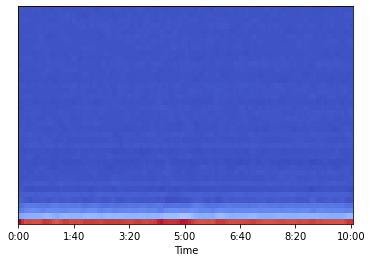

In [5]:
def extractFeatures(data, sample_rate=100, n_mfcc=40, max_pad_len=118):
   
    try:
        mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=n_mfcc)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return np.expand_dims(mfccs, -1)

x = readFile(dict_segments_paths_train[1588977747], sensor=9, mask_value=0)
print(x.shape)
x = extractFeatures(x, sample_rate=100, n_mfcc=40)
print(x.shape)
librosa.display.specshow(x.squeeze(), sr=100, x_axis='time')

(60000,)
(128, 235)


C:\Users\Enric\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Enric\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


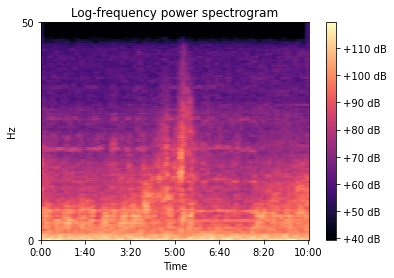

In [6]:
x = readFile(dict_segments_paths_train[1512562688], sensor=6, mask_value=0)
print(x.shape)
x = fileToMelspectrogram(x)
print(x.shape)
showMelspectrogram(x)

In [7]:
# bark = readAsMelspectogram(dict_segments_paths_train[1512562688], sensor=6, mask_value=0)
# bark_image = monoToColor(bark)

# plt.imshow(bark_image)
# plt.show()

# size = np.min([x.shape[0], x.shape[1]])
# cropped_bark_image = tf.image.random_crop(bark_image, size=(size, size, 3))

# plt.imshow(cropped_bark_image)
# plt.show()

In [8]:
def dumpSpectoGrams(segment, path_output, paths_files, mask_value=0):
    #for segment in tqdm(paths_files, total=len(paths_files), position=0):
    if not os.path.exists(f'{path_output}/{segment}/'):
        os.makedirs(f'{path_output}/{segment}/') 

    for s in range(10):
        img = readAsMelspectogram(paths_files[segment], sensor=s, mask_value=mask_value)
        img = monoToColor(img)
#         x = readFile(paths_files[segment], sensor=s, mask_value=0.0)
#         img = extractFeatures(x, sample_rate=100, n_mfcc=40)
#         img = monoToColor(img)

        np.save(f'{path_output}/{segment}/{segment}_{s}.npy', img)

In [10]:
# dumpSpectoGrams(path_spectograms, dict_segments_paths_train, mask_value=0)

num_processors = 16

# with parallel_backend('threading', n_jobs=num_processors):
#     Parallel()(delayed(dumpSpectoGrams)(segment, path_spectograms + 'train/', dict_segments_paths_train, mask_value=0) 
#               for segment in dict_segments_paths_train)
    
# print('Train finished!')
    
with parallel_backend('threading', n_jobs=num_processors):
    Parallel()(delayed(dumpSpectoGrams)(segment, path_spectograms + 'test/', dict_segments_paths_test, mask_value=0) 
              for segment in dict_segments_paths_test)
    
print('Test finished!')

Test finished!
